In [2]:

from qiskit import quantum_info
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import matplotlib.pyplot as plt
import numpy as np
import pickle
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, DensityMatrix, partial_trace
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
basis_gates=['ecr', 'id', 'rz', 'sx', 'x']
#InteractiveShell.ast_node_interactivity = "all"



In [3]:
def Shat(A,T,G): 
    
    t = np.tanh(T/4 + G/4)
    tt = np.tanh(T/4 - G/4)
    Shatf = np.array([[1-t*tt,0,0,t+tt],[0,1+t*tt,t-tt,0],[0,-t+tt,1+t*tt,0],[-t-tt,0,0,1-t*tt]],dtype=complex)
    Shatg = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]],dtype=complex)
    f = -(1j/4)*A*(2*np.cosh(T/2)+2*np.cosh(G/2))*(1/np.sinh(T/2))*(1/np.cosh(T/2))
    Shat = f*Shatf+Shatg
    Nalpha = 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)
    Shat = (-1/np.sqrt(Nalpha))*Shat
    return Shat


def Gperm():
    Gperm = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])
    return Gperm

def UBWOBC2(A,T,G):
    layer2= K1(-T/2)@K2(T/2)
    return 1j*(1/np.sqrt(Na(A,T,G)))*(1/Nk(T))*layer2@Shat(A,T,G)

def Ureal(A,T,G):  #NUMERICALLY CHECKED, CORRECT#
    
    Ur = np.zeros((4,4), dtype=complex)
    
    coef1=np.sqrt(1+A**(2)*(4*np.cosh(G/2)**(2)*(1/np.sinh(T)**(2))+(1/np.cosh(T/2)**2)))
    
    coef2=np.sqrt(2*A**(2)*(np.cosh(G)+np.cosh(T))+np.sinh(T)**2)
    
    
    Ur[0,0]=(1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    Ur[0,3]=(2*A*np.sinh(T/2))/coef2
    
    Ur[1,1]=(2*A*np.cosh(T/2))/coef2
    
    Ur[1,2]=(1j + 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,1]=(1j - 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,2]=(2*A*np.cosh(T/2))/coef2
    
    Ur[3,0]=-(2*A*np.sinh(T/2))/coef2
    
    Ur[3,3]=(-1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    return(Ur)


def prodstaten(n):   #CHECKED#
    
    X = np.array([[0,1],[1,0]])
    X0 = np.zeros((n,2**n,2**n),dtype = complex)
    
    for i in range(0,n):   
        X0[i]=np.kron(np.kron(np.eye(2**i),X),np.eye(2**(n-i-1)))
    operator = np.eye(2**n)
    for i in range(0,n//2):
        operator = (X0[2*i]-1j*X0[2*i+1])@operator
    return (1/np.sqrt(2**(n//2)))*operator


def K(T):
    
    K2 = Ur = np.zeros((2,2), dtype=complex)
    
    coef1 = np.cos(np.pi/4 + 1j*T/2)
    coef2 = np.cos(np.pi/4 - 1j*T/2)
    
    K2[0,0]=coef1
    K2[1,1]=coef2
    K2 = 1/np.sqrt(np.cosh(T)/2)*K2
    
    return K2

def Na(A,T,G):
    return 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)

def Nk(T):
    return (np.cosh(T/2))/2

dispcolors = {'cx':('#426299', '#000000'),
            'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}

 
def Q(T,G):
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    Id = np.array([[1,0],[0,1]])
    Q = np.exp(-(G+T)/4)*np.kron(X,Id)+np.exp((T+G)/4)*np.kron(Z,X)
    return Q

def Qbar(T,G):
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    Id = np.array([[1,0],[0,1]])
    Qbar = np.exp((T-G)/4)*np.kron(Y,Id)+np.exp(-(T-G)/4)*np.kron(Z,Y)

    return Qbar

In [11]:
#check supercharge commutations

A,T,G=3,3,3

print('Commutations for Ur: ',np.allclose(Q(T,G)@Ur(A,T,G)-Ur(A,T,G)@Q(-T,-G),0*np.eye(4)),
np.allclose(Qbar(T,G)@Ur(A,T,G)-Ur(A,T,G)@Qbar(-T,-G),0*np.eye(4)))


Commutations for Ur:  True True


In [7]:
#unitarity whole circuit (odd+even)
np.allclose((layer2@layer1)@(layer2@layer1).conj().T,np.eye(16))

NameError: name 'layer2' is not defined

In [14]:
#OBC BIPARTITION 4 sites, EE/RE


#Circuit parameters
n=4;A=1.2;G=20;

#Define arrays
 
thetas= np.arange(0.01,1,0.035)
layers = [1]
ent_entropy4 = np.zeros((len(layers),len(thetas)),dtype=complex)
renyi4 = np.zeros((len(layers),len(thetas)),dtype=complex)
eigvalsrho4 = np.zeros((len(layers),len(thetas),(2**(n//2))),dtype=complex)
subsystem = [0,1]

basis_gates=['cx', 'id', 'rz', 'x', 'sx']

for m,layer in enumerate(layers):
    #print(layer)
    
    for k,T in enumerate(thetas):    
        
        
        string = "0" * (n)
        qc = QuantumCircuit(n)
        QuantumCircuit.initialize(qc,string)
        #init with Kareljan's state
        #qc.unitary(prodstaten(n), range(0,n))
        qc.barrier(range(n))
        l=0
        while l<layer:
            qc.unitary(Shat(A,T,G),[0,1],label='S12')
            qc.unitary(Shat(A,T,G),[2,3],label='S34')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,G),[1,2],label='S23')
            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12')
            qc.unitary(Shat(A,T,0),[2,3],label='S34')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,-G),[1,2],label='S23')
            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,-G),[0,1],label='S12')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,-G),[1,2],label='S23')
            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12')
            qc.unitary(Shat(A,T,0),[2,3],label='S34')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,G),[1,2],label='S23')
            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            qc.barrier(range(4))
            l+=1
        #qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
        
        
        #######################################################################    
        #access density matrix  
        rho = DensityMatrix(qc)
        
        reduced_rho=partial_trace(rho, subsystem)
        
        #find the eigenvalues of the reduced density matrix
        eigenvalues,_ = np.linalg.eig(reduced_rho)
       
        #compute the entanglement entropy
        
        order = eigenvalues.argsort()
        eigenvalues = eigenvalues[order]
        eigvalsrho4[m,k,:]= eigenvalues
        entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
        renyi4[m,k]=-np.log(DensityMatrix.purity(reduced_rho))
        ent_entropy4[m,k]=entanglement_entropy
        #print(k,ent_entropy[k])
        ######################################################################
with open('L=4_OBC_Renyi_exact_mesh='+str(len(thetas))+'.pkl', 'wb') as file:
    
   #A new file will be created
   pickle.dump(renyi4, file)             

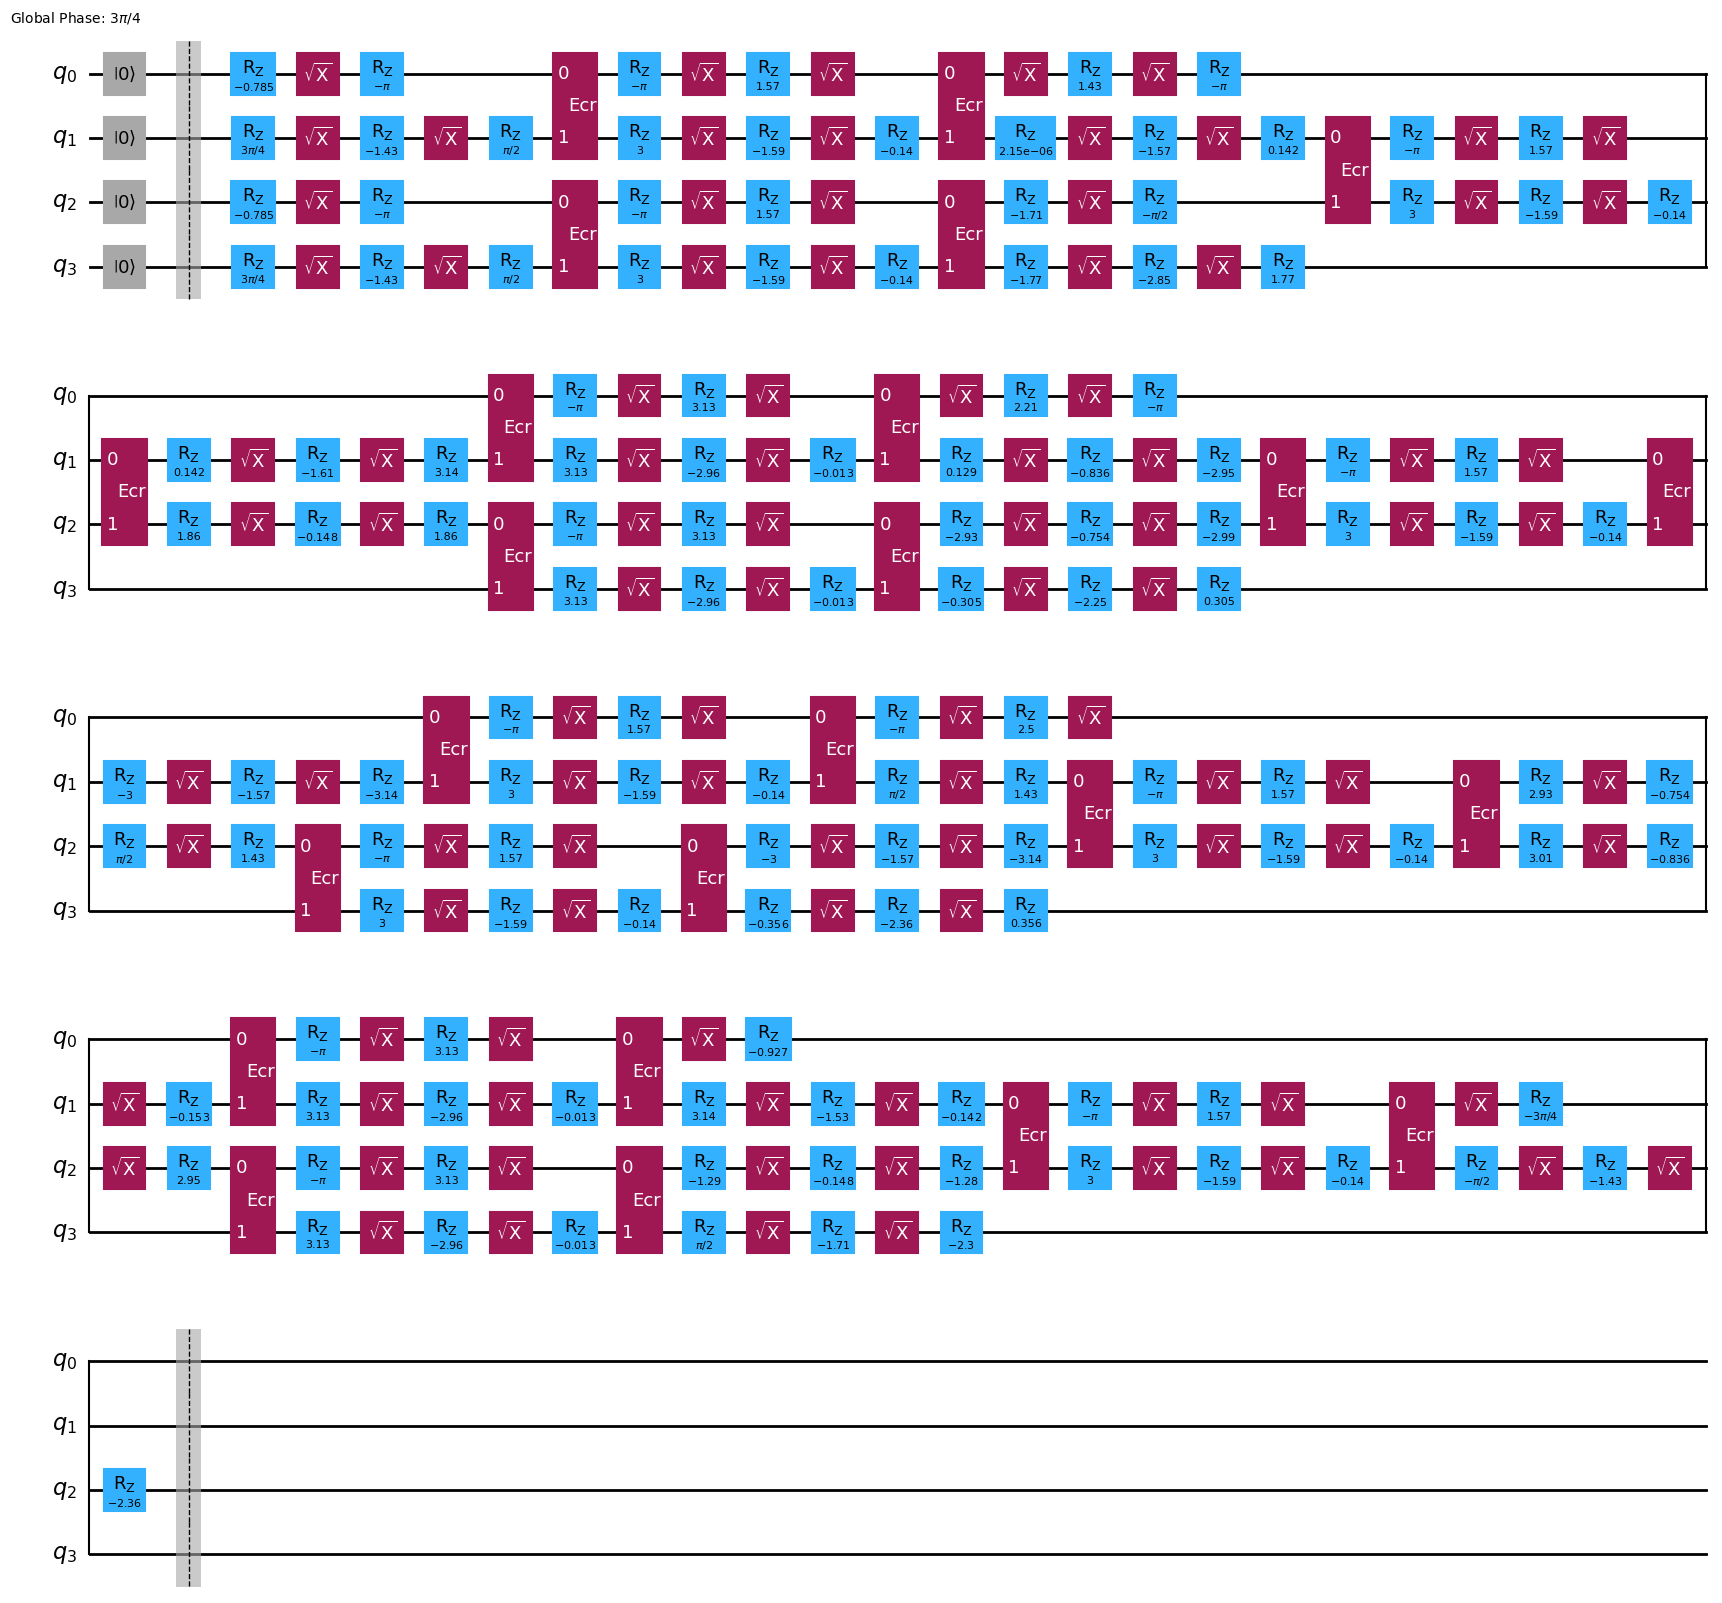

In [3]:
#debug 4 sites
n=4;A=1.2;G=20;T=0.2
string = "0" * (n)
qc = QuantumCircuit(n)
QuantumCircuit.initialize(qc,string)
#init with Kareljan's state
#qc.unitary(prodstaten(n), range(0,n))
qc.barrier(range(n))
layer=1
l=0
while l<layer:
    qc.unitary(Shat(A,T,G),[0,1],label='S12')
    qc.unitary(Shat(A,T,G),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12')
    qc.unitary(Shat(A,T,0),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,-G),[0,1],label='S12')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12')
    qc.unitary(Shat(A,T,0),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    qc.barrier(range(4))
    l+=1
qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

########################################################################    
##access density matrix  
#rho = DensityMatrix(qc)
#
#reduced_rho=partial_trace(rho, subsystem)
#
##find the eigenvalues of the reduced density matrix
#eigenvalues,_ = np.linalg.eig(reduced_rho)
#
##compute the entanglement entropy
#
#order = eigenvalues.argsort()
#eigenvalues = eigenvalues[order]
#
#entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
#
#print(entanglement_entropy)

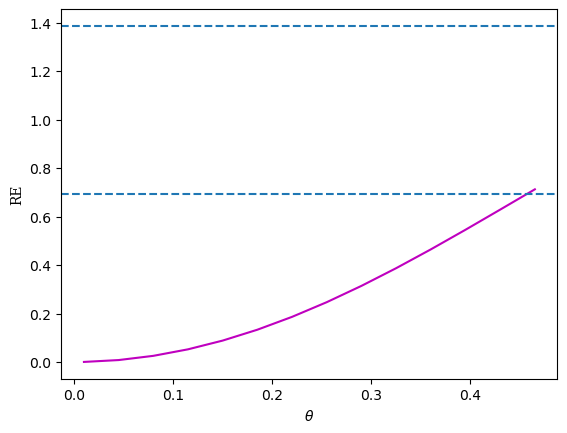

In [66]:
csfont = {'fontname':'Serif'}
from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(layers))))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, len(layers))))
leng= np.array([2,3,4],dtype=int)

for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    plt.plot(thetas,renyi4[j]+j*np.log(2),'-', c='m',label='L=4')
    color2 = next(color_cycle2)
    #plt.plot(thetas,renyi4[j],'-.', c=color2,label='RE')
    
    
#plt.plot(thetas,eigvalsrho4[0,:],'-.')


#plt.title('OBC N='+str(n)+', A= '+str(A)+' G='+str(G)+' init 0',**csfont)
for j in range(1,3):
    plt.axhline(y=j*np.log(2), linestyle='--')

plt.xlabel(r'$\theta$',**csfont)
plt.ylabel('RE', **csfont)

  


#plt.xlim(-0.2,3)
#plt.ylim(0,3)
#plt.legend()   
#plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/OBC 4 site A=1.2 G=20.pdf", bbox_inches='tight')  

In [49]:
#OBC BIPARTITION 6 sites, varying layers per datapoint


#Circuit parameters
n=6
A,G,=1.2,20
#Define arrays
 
thetas= np.arange(1e-3,5,0.05)
layers = [1]
ent_entropy6 = np.zeros((len(layers),len(thetas)),dtype=complex)
renyi6 = np.zeros((len(layers),len(thetas)),dtype=complex)
eigvalsrho6 = np.zeros((len(layers),len(thetas),(2**(n//2))),dtype=complex)
subsystem = [j for j in range(n//2)]

basis_gates=['cx', 'id', 'rz', 'x', 'sx']

print(subsystem)

for m,layer in enumerate(layers):
    print(layer)
    
    for k,T in tqdm(enumerate(thetas)):    
        
        
        string = "0" * (n)
        qc = QuantumCircuit(n)
        QuantumCircuit.initialize(qc,string)
        #init with Kareljan's state
        #qc.unitary(prodstaten(n), range(0,n))
        qc.barrier(range(n))
        l=0
        while l<layer:
            qc.unitary(Shat(A,T,G),[0,1],label='S12 G')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,0),[3,4],label='S45 0')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,-G),[0,1],label='S12 -')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,0),[3,4],label='S45 0')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
            
            qc.barrier(range(n))
            l+=1
        qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
        
        
        #######################################################################    
        #access density matrix  
        rho = DensityMatrix(qc)
        
        reduced_rho=partial_trace(rho, subsystem)
        
        #find the eigenvalues of the reduced density matrix
        eigenvalues,_ = np.linalg.eig(reduced_rho)
       
        #compute the entanglement entropy
        
        order = eigenvalues.argsort()
        eigenvalues = eigenvalues[order]
        eigvalsrho6[m,k,:]= eigenvalues
        entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
        renyi6[m,k]=-np.log(DensityMatrix.purity(reduced_rho))
        ent_entropy6[m,k]=entanglement_entropy
        #print(k,ent_entropy[k])
        ######################################################################
            

[0, 1, 2]
1


100it [00:18,  5.49it/s]


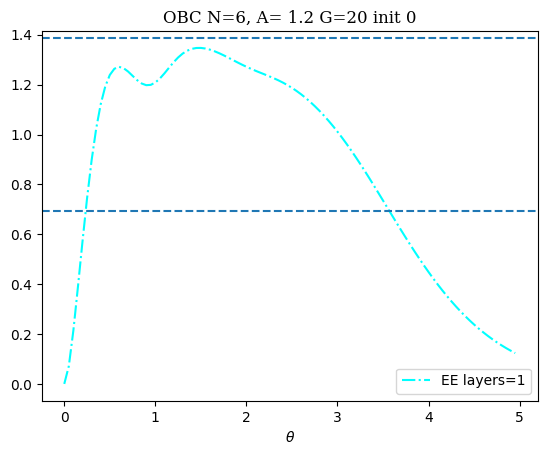

In [50]:
csfont = {'fontname':'Serif'}
from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(layers))))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, len(layers))))
leng= np.array([2,3,4],dtype=int)

for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    plt.plot(thetas,ent_entropy6[j],'-.', c=color1,label='EE layers='+str(layer))
    color2 = next(color_cycle2)
    #plt.plot(thetas,renyi6[j],'-.', c=color2,label='RE')
    
    
#plt.plot(thetas,eigvalsrho6[0,:],'-,')


plt.title('OBC N='+str(n)+', A= '+str(A)+' G='+str(G)+' init 0',**csfont)
for j in range(1,3):
    plt.axhline(y=j*np.log(2), linestyle='--')

plt.xlabel(r'$\theta$',**csfont)
#plt.xlim(-0.2,3.8)
#plt.ylim(-0,3)
plt.legend()   


In [29]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="253c04c1782fbe76188d45069e8bb89a54c779e469a1e55417ad64306275238b8f7d6030db8b71b4292b2239a70d14290b4781376aeef8c98f239d8078a5e291",overwrite=True)
basis_gates=['ecr', 'id', 'rz', 'sx', 'x']

In [30]:
#debug 6 
n=6;A=1.2;G=20;T=0.2

layers = [1]
ent_entropy = np.zeros((len(layers),len(thetas)),dtype=complex)
renyi = np.zeros((len(layers),len(thetas)),dtype=complex)
eigvalsrho = np.zeros((len(layers),len(thetas),(2**(n//2))),dtype=complex)
subsystem = [0,1,2]

string = "0" * (n)
qc = QuantumCircuit(n)
QuantumCircuit.initialize(qc,string)
#init with Kareljan's state
#qc.unitary(prodstaten(n), range(0,n))
qc.barrier(range(n))
l=0
while l<layer:
    qc.unitary(Shat(A,T,G),[0,1],label='S12 G')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,0),[3,4],label='S45 0')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,-G),[0,1],label='S12 -')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,0),[3,4],label='S45 0')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
    
    qc.barrier(range(n))
    l+=1
#qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)

#######################################################################    
#access density matrix  
rho = DensityMatrix(qc)
reduced_rho=partial_trace(rho, subsystem)
#find the eigenvalues of the reduced density matrix
eigenvalues,_ = np.linalg.eig(reduced_rho)
#compute the entanglement entropy
order = eigenvalues.argsort()
eigenvalues = eigenvalues[order]
eigvalsrho[m,k,:]= eigenvalues
entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
renyi[m,k]=-np.log(DensityMatrix.purity(reduced_rho))
ent_entropy[m,k]=entanglement_entropy
#print(k,ent_entropy[k])
######################################################################
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

NameError: name 'thetas' is not defined

In [44]:
#drift 6 sites
n=6;A=1;G=0.000001;T=1

layers = [1]
occupations = []

#init with Kareljan's state
#qc.unitary(prodstaten(n), range(0,n))
qc.barrier(range(n))

for i,l in enumerate(layers):

    string = "000100" 
    qc = QuantumCircuit(n)
    QuantumCircuit.initialize(qc,string)

    t=0
    while t<l:
        qc.unitary(Shat(A,T,G),[0,1],label='S12 G')
        qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
        qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
        qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
        qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
        
        qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
        qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
        qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
        qc.unitary(Shat(A,T,0),[3,4],label='S45 0')
        qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
        
        qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
        qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
        qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
        qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
        qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
        
        qc.unitary(Shat(A,T,-G),[0,1],label='S12 -')
        qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
        qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
        qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
        qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
        
        qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
        qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
        qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
        qc.unitary(Shat(A,T,0),[3,4],label='S45 0')
        qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
        
        qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
        qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
        qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
        qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
        qc.unitary(K(T/2),[5],label=r'$K(\theta/2)$')
        qc.barrier(range(n))
        t+=1
        
    qc.measure_all()
    ######EXECUTION########
    #specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
    service = QiskitRuntimeService(channel="ibm_quantum")
    backend = service.backend("simulator_statevector")
    #backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
    qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
    #pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    
    
    
    with Session(service, backend=backend) as session:
        sampler = Sampler(session=session)
        job = sampler.run(qc, shots=1000,resilience_level=1)
        result = job.result()

    # Get the results
    
    occupations.append(result.quasi_dists[0].binary_probabilities())
print(occupations)
#qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

[{'000001': 0.086, '000010': 0.096, '000111': 0.018, '001000': 0.003, '001011': 0.04, '001101': 0.002, '001110': 0.006, '010000': 0.149, '010011': 0.01, '010101': 0.01, '010110': 0.023, '011001': 0.034, '011010': 0.012, '011100': 0.008, '011111': 0.006, '100000': 0.117, '100011': 0.029, '100101': 0.011, '100110': 0.01, '101001': 0.005, '101010': 0.058, '101100': 0.004, '101111': 0.001, '110001': 0.081, '110010': 0.094, '110100': 0.013, '110111': 0.014, '111000': 0.039, '111011': 0.005, '111101': 0.001, '111110': 0.015}]


In [ ]:
#OBC BIPARTITION 8 sites, varying layers per datapoint


#Circuit parameters
n=8;A=1.2;G=20;

#Define arrays
 
thetas= np.arange(1e-3,10,0.05)
layers = [1]
ent_entropy8 = np.zeros((len(layers),len(thetas)),dtype=complex)
renyi8 = np.zeros((len(layers),len(thetas)),dtype=complex)
eigvalsrho8 = np.zeros((len(layers),len(thetas),(2**(n//2))),dtype=complex)
subsystem = [j for j in range(n//2)]

basis_gates=['cx', 'id', 'rz', 'x', 'sx']

print(subsystem)

for m,layer in enumerate(layers):
    print(layer)
    
    for k,T in tqdm(enumerate(thetas)):    
        
        
        string = "0" * (n)
        qc = QuantumCircuit(n)
        QuantumCircuit.initialize(qc,string)
        #init with Kareljan's state
        #qc.unitary(prodstaten(n), range(0,n))
        qc.barrier(range(n))
        l=0
        while l<layer:
            qc.unitary(Shat(A,T,G),[0,1],label='S12 G')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
            qc.unitary(Shat(A,T,G),[6,7],label='S78 G')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(Shat(A,T,G),[5,6],label='S67 G')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,0),[2,3],label='S34 0')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(Shat(A,T,-G),[5,6],label='S67 -')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,-G),[0,1],label='S12 -')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
            qc.unitary(Shat(A,T,-G),[6,7],label='S78 -')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(Shat(A,T,-G),[5,6],label='S67 -')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
            qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
            qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,0),[2,3],label='S34 0')
            qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            
            qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
            qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
            qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
            qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
            qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
            qc.unitary(Shat(A,T,G),[5,6],label='S67 G')
            qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
            qc.barrier(range(n))
            l+=1
        qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
        
        
        #######################################################################    
        #access density matrix  
        rho = DensityMatrix(qc)
        
        reduced_rho=partial_trace(rho, subsystem)
        
        #find the eigenvalues of the reduced density matrix
        eigenvalues,_ = np.linalg.eig(reduced_rho)
       
        #compute the entanglement entropy
        
        order = eigenvalues.argsort()
        eigenvalues = eigenvalues[order]
        eigvalsrho8[m,k,:]= eigenvalues
        entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
        renyi8[m,k]=-np.log(DensityMatrix.purity(reduced_rho))
        ent_entropy8[m,k]=entanglement_entropy
        #print(k,ent_entropy[k])
        ######################################################################
            

[0, 1, 2, 3]
1


63it [00:57,  1.08it/s]

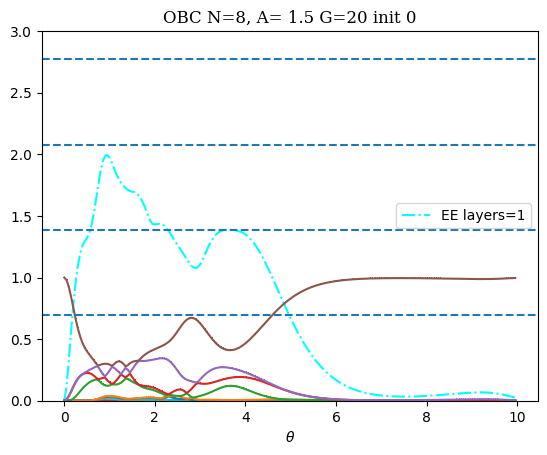

In [63]:
csfont = {'fontname':'Serif'}
from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(layers))))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, len(layers))))
leng= np.array([2,3,4],dtype=int)

for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    plt.plot(thetas,ent_entropy8[j]+j*np.log(2),'-.', c=color1,label='EE layers='+str(layer))
    color2 = next(color_cycle2)
    #plt.plot(thetas,renyi8[j],'-.', c=color2,label='RE')
    
    
plt.plot(thetas,eigvalsrho8[0,:],'-,')


plt.title('OBC N='+str(n)+', A= '+str(A)+' G='+str(G)+' init 0',**csfont)
for j in range(1,5):
    plt.axhline(y=j*np.log(2), linestyle='--')

plt.xlabel(r'$\theta$',**csfont)
#plt.xlim(-0.2,3.8)
plt.ylim(-0,3)
plt.legend()   


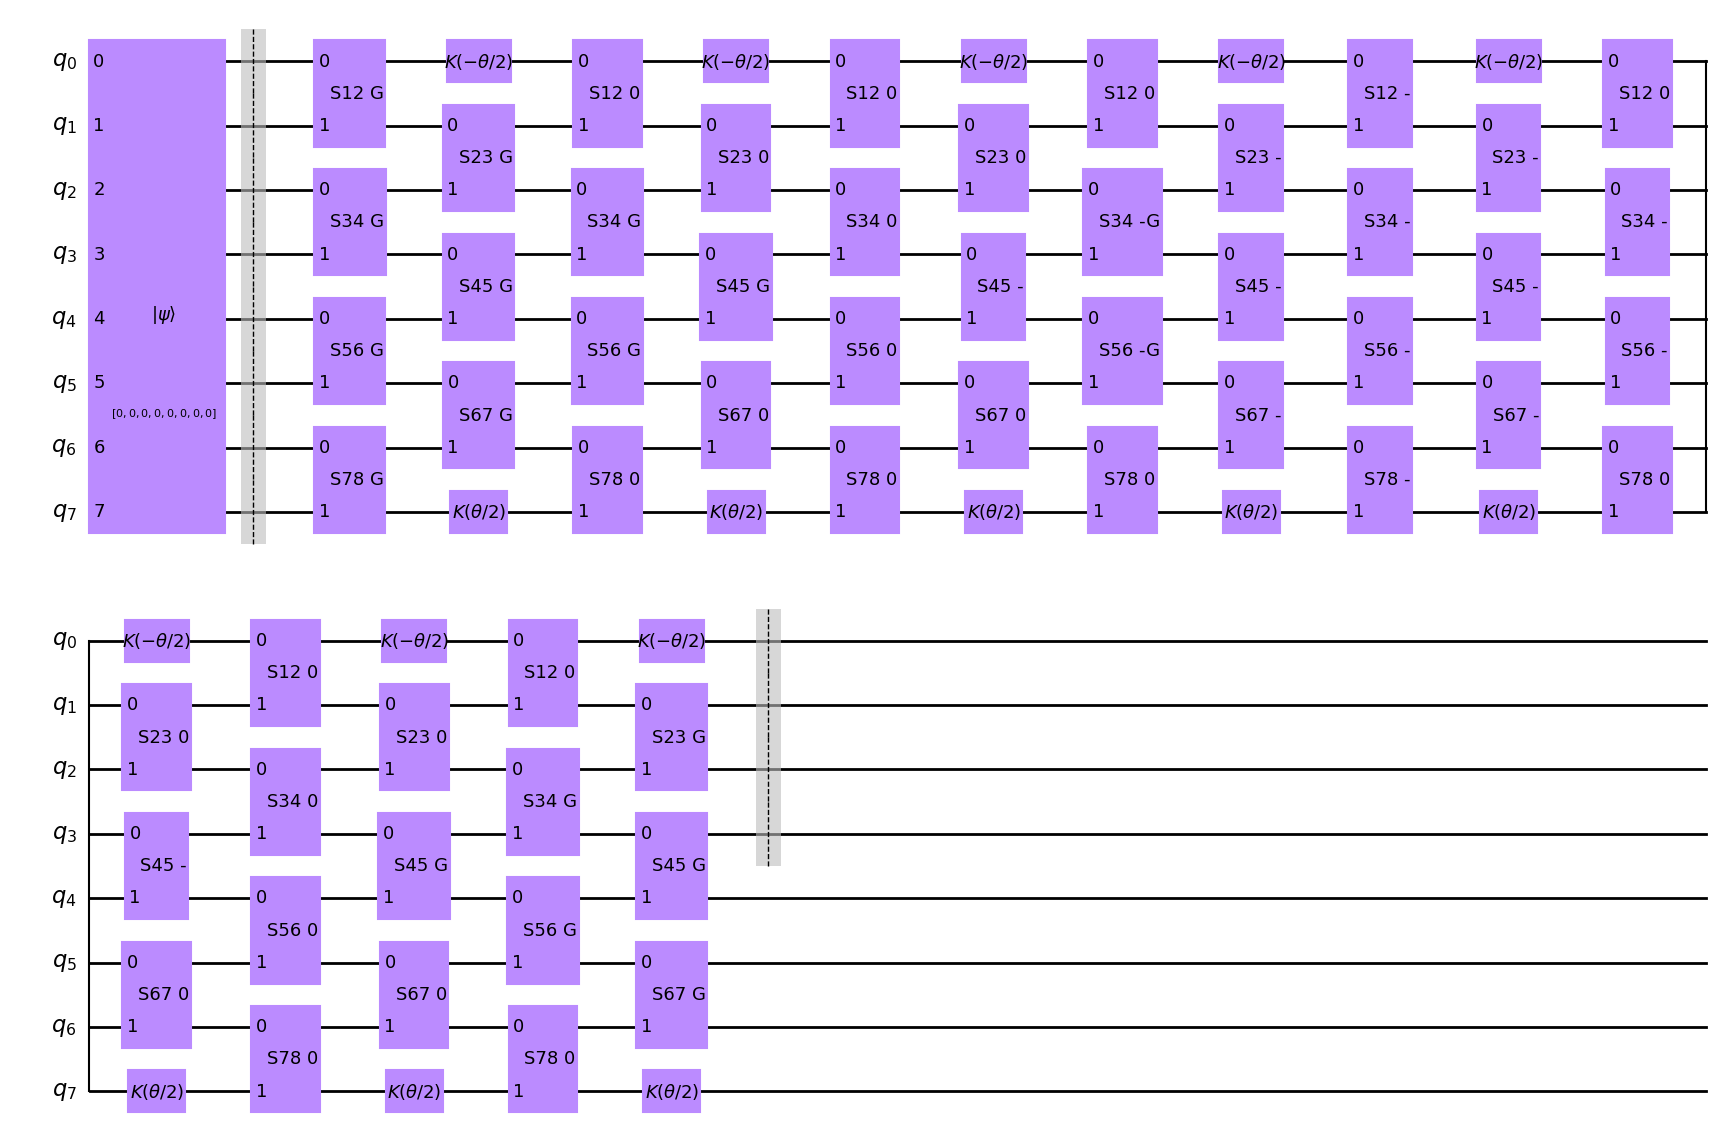

In [413]:
#debug 8 site
A=1;G=0;n=8
string = "0" * (n)
qc = QuantumCircuit(n)
QuantumCircuit.initialize(qc,string)
#init with Kareljan's state
#qc.unitary(prodstaten(n), range(0,n))
qc.barrier(range(n))
l=0
while l<layer:
    qc.unitary(Shat(A,T,G),[0,1],label='S12 G')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
    qc.unitary(Shat(A,T,G),[6,7],label='S78 G')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(Shat(A,T,G),[5,6],label='S67 G')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,0),[2,3],label='S34 0')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(Shat(A,T,-G),[5,6],label='S67 -')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,-G),[0,1],label='S12 -')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
    qc.unitary(Shat(A,T,-G),[6,7],label='S78 -')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23 -')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(Shat(A,T,-G),[5,6],label='S67 -')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34 -')
    qc.unitary(Shat(A,T,-G),[4,5],label='S56 -')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,-G),[3,4],label='S45 -')
    qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,0),[2,3],label='S34 0')
    qc.unitary(Shat(A,T,0),[4,5],label='S56 0')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,0),[1,2],label='S23 0')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(Shat(A,T,0),[5,6],label='S67 0')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12 0')
    qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
    qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
    qc.unitary(Shat(A,T,0),[6,7],label='S78 0')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
    qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
    qc.unitary(Shat(A,T,G),[5,6],label='S67 G')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
    
    qc.barrier(range(4))
    l+=1
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

/home/alberto/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


NameError: name 'renyi6' is not defined

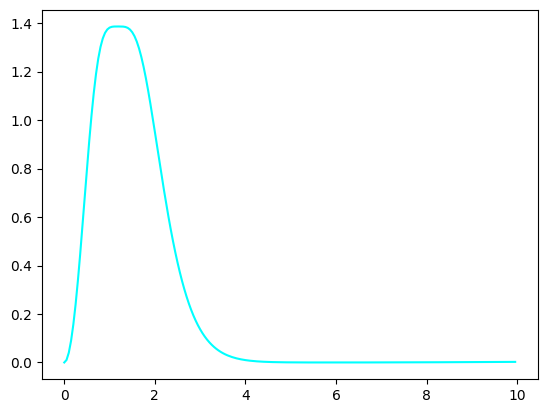

In [23]:
#PLOT ALL SIZES
csfont = {'fontname':'Serif'}
thetas= np.arange(1e-3,10,0.05)

from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, 3)))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, 3)))
leng= np.array([2,3,4],dtype=int)

for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    #plt.plot(thetas,ent_entropy4[j],'-.', c=color1,label='EE size=4')
    color2 = next(color_cycle2)
    plt.plot(thetas,renyi4[j],'-', c=color1,label='L=4')
    
for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    #plt.plot(thetas,ent_entropy6[j],'-.', c=color1,label='EE size=6')
    color2 = next(color_cycle2)
    plt.plot(thetas,renyi6[j],'-', c=color1,label='L=6')
    
for j,layer in enumerate(layers):
    color1 = next(color_cycle1)
    #plt.plot(thetas,ent_entropy8[j],'-.', c=color1,label='EE size=8')
    color2 = next(color_cycle2)
    plt.plot(thetas,renyi8[j],'-', c=color1,label='L=8')
    



#plt.title('OBC A= '+str(A)+' G='+str(G)+' init 0',**csfont)
for j in range(1,4):
    plt.axhline(y=j*np.log(2), linestyle='--')
    
plt.xlabel(r'$\theta$', **csfont)
plt.xlabel(r'$\theta$')
#plt.xlim(-0.2,3.8)
#plt.ylim(-0.1,1.5)
plt.legend()   
plt.show()
plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/OBC 4,6,8 site A=1.2 G=20.pdf", bbox_inches='tight')  

In [3]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
aer_sim=AerSimulator()
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [46]:
#debug 8 site
A=1;G=2;T=1;n=8
string = "00111100"
occupations = []
qc = QuantumCircuit(n)
QuantumCircuit.initialize(qc,string)
#init with Kareljan's state
#qc.unitary(prodstaten(n), range(0,n))
qc.barrier(range(n))


qc.unitary(Shat(A,T,G),[0,1],label='S12 G')
qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
qc.unitary(Shat(A,T,G),[6,7],label='S78 G')
qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
qc.unitary(Shat(A,T,G),[5,6],label='S67 G')
qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
qc.measure_all()
#qc.draw(output='mpl')

######EXECUTION########

backend = aer_sim
shots=1000
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
print('b')
with Session(backend=aer_sim) as session:
    sampler = Sampler(session=session)
    result = sampler.run([isa_qc], shots=shots).result()

# Get the results
print('c')
counts = result[0].data.meas.get_counts()
occupations.append(counts)
#occupations.append(result.quasi_dists[0].binary_probabilities())
#print(occupations)
#qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')       
    



b
c


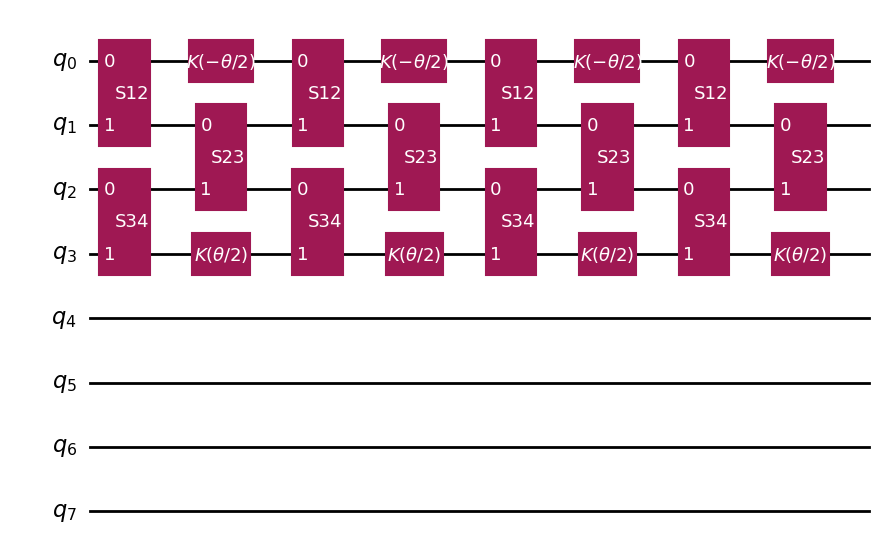

In [6]:
qc = QuantumCircuit(8)
A,T,G=1,1,1
qc.unitary(Shat(A,T,G),[0,1],label='S12')
qc.unitary(Shat(A,T,G),[2,3],label='S34')
qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
qc.unitary(Shat(A,T,G),[1,2],label='S23')
qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')

qc.unitary(Shat(A,T,0),[0,1],label='S12')
qc.unitary(Shat(A,T,0),[2,3],label='S34')
qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
qc.unitary(Shat(A,T,-G),[1,2],label='S23')
qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')

qc.unitary(Shat(A,T,-G),[0,1],label='S12')
qc.unitary(Shat(A,T,-G),[2,3],label='S34')
qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
qc.unitary(Shat(A,T,-G),[1,2],label='S23')
qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')

qc.unitary(Shat(A,T,0),[0,1],label='S12')
qc.unitary(Shat(A,T,0),[2,3],label='S34')
qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
qc.unitary(Shat(A,T,G),[1,2],label='S23')
qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
qc.draw(output='mpl')

In [12]:
def OBCassembler(qc,a,t,g,n):
    #even layer
    for i in range(n//2):
        qc.unitary(Shat(a,t,g),[2*i,2*i+1])
    #odd layer 
    qc.unitary(K(t),[0],label='K')
    qc.unitary(K(t),[n-1],label='K')
    return(qc)


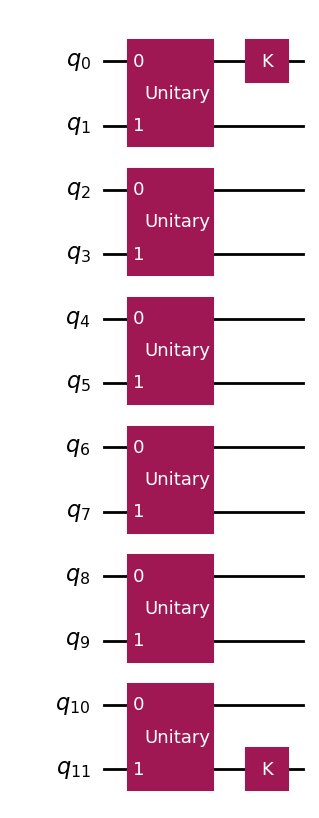

In [13]:
n=12
qc = QuantumCircuit(n)
OBCassembler(qc,1,1,1,n)
qc.draw(output='mpl')

In [2]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
aer_sim=AerSimulator()
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [44]:
#drift 8 sites OBC
n=8;A=1;G=8;T=1e-14;layers=20

layers = [j for j in range(1,layers)]
occupations_dict = {}



for _,l in enumerate(layers): 
    string = "00011000" 
    qc = QuantumCircuit(n)
    QuantumCircuit.initialize(qc,string)
    matrix = Ureal(A,T,G)
    u=0
    while u<l:
        qc.unitary(Shat(A,T,G),[0,1],label='S12 G')
        qc.unitary(Shat(A,T,G),[2,3],label='S34 G')
        qc.unitary(Shat(A,T,G),[4,5],label='S56 G')
        qc.unitary(Shat(A,T,G),[6,7],label='S78 G')
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        qc.unitary(Shat(A,T,G),[1,2],label='S23 G')
        qc.unitary(Shat(A,T,G),[3,4],label='S45 G')
        qc.unitary(Shat(A,T,G),[5,6],label='S67 G')
        qc.unitary(K(T/2),[7],label=r'$K(\theta/2)$')
        u+=1
    qc.measure_all()
    #qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)

    #print('a')
    ######EXECUTION########

    backend = aer_sim
    shots=1000
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
    isa_qc = pm.run(qc)
    #print('b')
    with Session(backend=aer_sim) as session:
        sampler = Sampler(session=session)
        result = sampler.run([isa_qc], shots=shots).result()

    # Get the results
    #print('c')
    counts = result[0].data.meas.get_counts()
    #print(len(counts))
    #print('layer',l)
    occupations_dict[f'occupations_{l}']=counts
#qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')       
    



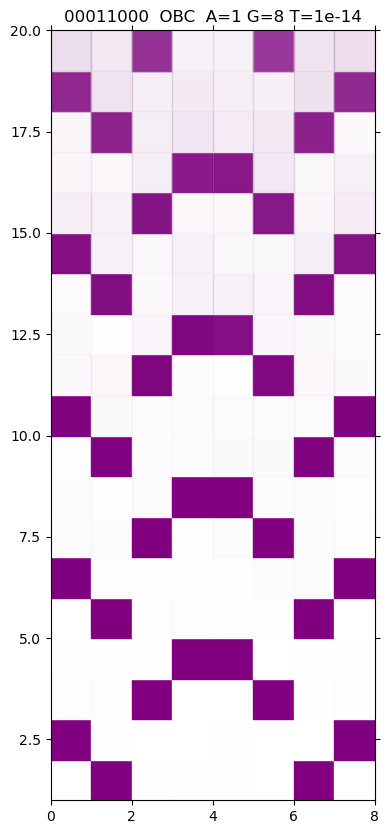

In [45]:
# Define the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))


# Set the aspect ratio to be equal
ax.set_aspect('equal')

# Set limits for the x-axis
ax.set_xlim(0, 8)
ax.set_ylim(1, len(occupations_dict.keys())+1)

for h,vals in enumerate(occupations_dict.values()):
    #set max value of opacity
    max_val=max(vals.values())
    max_val=max_val/shots
    #print(max_val)
    # Loop through the dictionary items and plot the squares
    for i, (binary, value) in enumerate(vals.items()):
        #print(binary,value)
        for j in range(8):
            x = j  # x-coordinate
            y = i  # y-coordinate
            
            # Determine color based on binary value
            color = 'purple' if binary[j] == '1' else 'white'
            
            # Determine opacity based on value
            opacity = (value/shots)/max_val
            
            # Draw the square
            ax.add_patch(plt.Rectangle((x, h+1), 1, 1, color=color, alpha=opacity))

# Hide the axes
#ax.axis('off')
# Show the ticks on both axes
plt.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True)


plt.title(string+'  OBC  A='+str(A)+' G='+str(G)+' T='+str(T))
# Show the plot
plt.show()